# Data cleaning: Stop and search in the UK

## Contents

1. [Introduction](#section-intro)
2. [Data Collection](#section-env)
3. [Data Cleaning](#section-clean)  
  3.1. [Column renaming](#section-rename)  
  3.2. [Data Type conversion](#section-convert)  
  3.3. [Remove Columns](#section-remove)  
  3.4. [Replace missing values](#section-replace)  
  3.5. [Check for outliers](#section-outliers)  
  3.6. [Deal with Duplicates](#section-dupl)
4. [Data Analysis and Visualization](#section-viz)  
5. [Main findings](#section-findings)



<a id="section-intro"></a>
## 1. Introduction  
This analysis focuses on the police stop and search figures provided by the UK Government at [data.gov.uk](https://www.ethnicity-facts-figures.service.gov.uk/crime-justice-and-the-law/policing/stop-and-search/latest). It's main aim is to understand the data available, and to clean it appropriately using the R programming language. Some analysis and visualization also takes place at the end!

To provide some background, a police officer has powers to stop and search you in the UK if they have ‘reasonable grounds’ to suspect you’re carrying illegal drugs, a weapon, stolen property or something which could be used to commit a crime. You can only be stopped and searched without reasonable grounds if it has been approved by a senior police officer. This can happen if it is suspected that: a) serious violence could take place b) you’re carrying a weapon or have used one c) you’re in a specific location or area. Being searched doesn’t mean you’re being arrested.

As part of the process, the police officers ask for a name and address, date of birth and *self-defined* ethnicity. One doesn't have to give this information if they don't want to; unless the police officer says they're reporting them for an offence.

<a id="section-env"></a>
## 2. Data Collection

Let's start by loading the libraries and the data we'll need:

In [1]:
# libraries we'll need
library(tidyverse)
library(lubridate)
library(maps)

# read in the data we'll need
stop_and_search_raw <- read_csv("/kaggle/input/stop-and-search-by-ethnicity-uk/stop-and-search-data.csv") %>%
    janitor::clean_names()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map


Rows: 17748 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): Measure, Time, Time_type, Ethnicity, Ethnicity_type, Legislation_t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this messa

In [2]:
glimpse(stop_and_search_raw)

Rows: 17,748
Columns: 13
$ measure                                                                                                                  <chr> …
$ time                                                                                                                     <chr> …
$ time_type                                                                                                                <chr> …
$ ethnicity                                                                                                                <chr> …
$ ethnicity_type                                                                                                           <chr> …
$ legislation_type                                                                                                         <chr> …
$ geography                                                                                                                <chr> …
$ geography_type                                          

We first need to understand what the data refers to: it provides 17,748 data points with the number of stops and searches by police in the UK, grouped by regions, ethnicity of the person stoped, the reason behind the stop (legislation_type), as well as the population of various ethnicities in the various regions. There is also a distinction between total cases, and cases where ethnicity wasn't reported. The calculated metrics provided are:
> **'Rate per 1,000 population by ethnicity'**: Number of stops for an ethnicity, divided by the Total population of the ethnicity in the region (rate per 1000).  
> **'Proportion of total stop and searches of this ethnicity in the financial year (excludes unreported)'**:  Number of stops for an ethnicity, divided by the Total number of stops (rate per 100).

Is our data reliable? According to the ROACC approach:
> **R**eliable: Completeness HIGH (full data 2006-2020 for all UK Police Force Areas), while the accuracy will be assessed once cleaning has been completed  
> **O**riginal: MED — Second party provider (UK Police Stations)  
> **C**omprehensive: HIGH — The metrics are clear and comparable  
> **C**urrent: MED — Data is as recent as 2020  
> **C**ited: HIGH — Data title, source and parties responsible are clear  

<a id="section-clean"></a>
## 3. Data cleaning

<a id="section-rename"></a>
### 3.1. Column renaming
Let's start by renaming some columns whose length makes them unhandy:

In [3]:
stop_and_search_raw <- stop_and_search_raw %>% 
       rename(total_number_with_reported_ethnicity = 10, proportion_ethnicity_to_total_stops = 13)

<a id="section-convert"></a>
### 3.2. Data type conversion
R has read all our columns as character data types. We therefore need to convert them appropriately, where needed:
- Time column: from character to number. The date provided is that of a financial year (e.g. 2006/07). We will extract the first 4 characters to get just the first year of the two, and then convert it to an integer data type so we can plot it. 

In [4]:
stop_and_search_raw$time <- as.integer(substring(stop_and_search_raw$time,0,4))

# Let's check that the conversion has been successful

class(stop_and_search_raw$time)
unique(stop_and_search_raw$time)

[1] "integer"

[1] 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020

Next, let's check the values of the various columns:

In [5]:
sort(unique(stop_and_search_raw$measure)) # As it contains the same value for all data points, it can be dropped
sort(unique(stop_and_search_raw$time_type)) # As it contains the same value for all data points, it can be dropped
sort(unique(stop_and_search_raw$ethnicity))
sort(unique(stop_and_search_raw$ethnicity_type))
sort(unique(stop_and_search_raw$geography_type)) # As it contains the same value for all data points, it can be dropped

[1] "Number of stops and searches carried out (excluding vehicle only searches)"

[1] "Financial year"

[1] "All"                                       
 [2] "Any Other Asian Background"                
 [3] "Any Other Black Background"                
 [4] "Any Other Ethnic Group"                    
 [5] "Any Other Mixed/Multiple Ethnic Background"
 [6] "Any Other White Background"                
 [7] "Arab"                                      
 [8] "Asian"                                     
 [9] "Bangladeshi"                               
[10] "Black"                                     
[11] "Black African"                             
[12] "Black Caribbean"                           
[13] "Chinese"                                   
[14] "Gypsy Or Irish Traveller"                  
[15] "Indian"                                    
[16] "Mixed"                                     
[17] "Mixed White And Asian"                     
[18] "Mixed White And Black African"             
[19] "Mixed White And Black Caribbean"           
[20] "Other"                                     
[21] "Other Inc Chinese"                         
[22] "Pakistani"                                 
[23] "Unreported"                                
[24] "White"                                     
[25] "White British"                             
[26] "White Irish"

[1] "All"           "ONS 2001 16+1" "ONS 2001 5+1"  "ONS 2011 18+1"
[5] "ONS 2011 5+1"

[1] "Police Force Area"

<a id="section-col-spec"></a>
Columns 'measure', 'time_type', 'geography_type' can be removed as they have the same value for all data points (see [Removing columns we don't need](#section-remove)).

Let's check out the legislation type:

In [6]:
sort(unique(stop_and_search_raw$legislation_type))

[1] "All"            "Section 1"      "Section 44/47a" "Section 60"

Through an online search we find out that:
> **Section 1**: An officer can stop, detain, and search any person or vehicle in a public place, as long as the officer has 'reasonable grounds' for suspecting that they will find stolen or prohibited articles.  
> **Section 44/47a (Terrorism Act)**: Enables a senior police officer to authorise 'suspicionless' stop and searches within a specific area for a limited time.  
> **Section 60**: Used to prevent and detect the carrying of dangerous instruments or offensive weapons.  

Let's now have a look at the map of the areas examined. To map our locations, we will use the latitude and longitude data provided for each Police Force Area by the [UK Open Geography Portal](https://geoportal.statistics.gov.uk/datasets/police-force-areas-dec-2021-ew-bfe/explore?location=53.504108%2C-0.229704%2C5.99).

Rows: 43 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): PFA21CD, PFA21NM, GlobalID
dbl (7): OBJECTID, BNG_E, BNG_N, LONG, LAT, Shape__Area, Shape__Length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


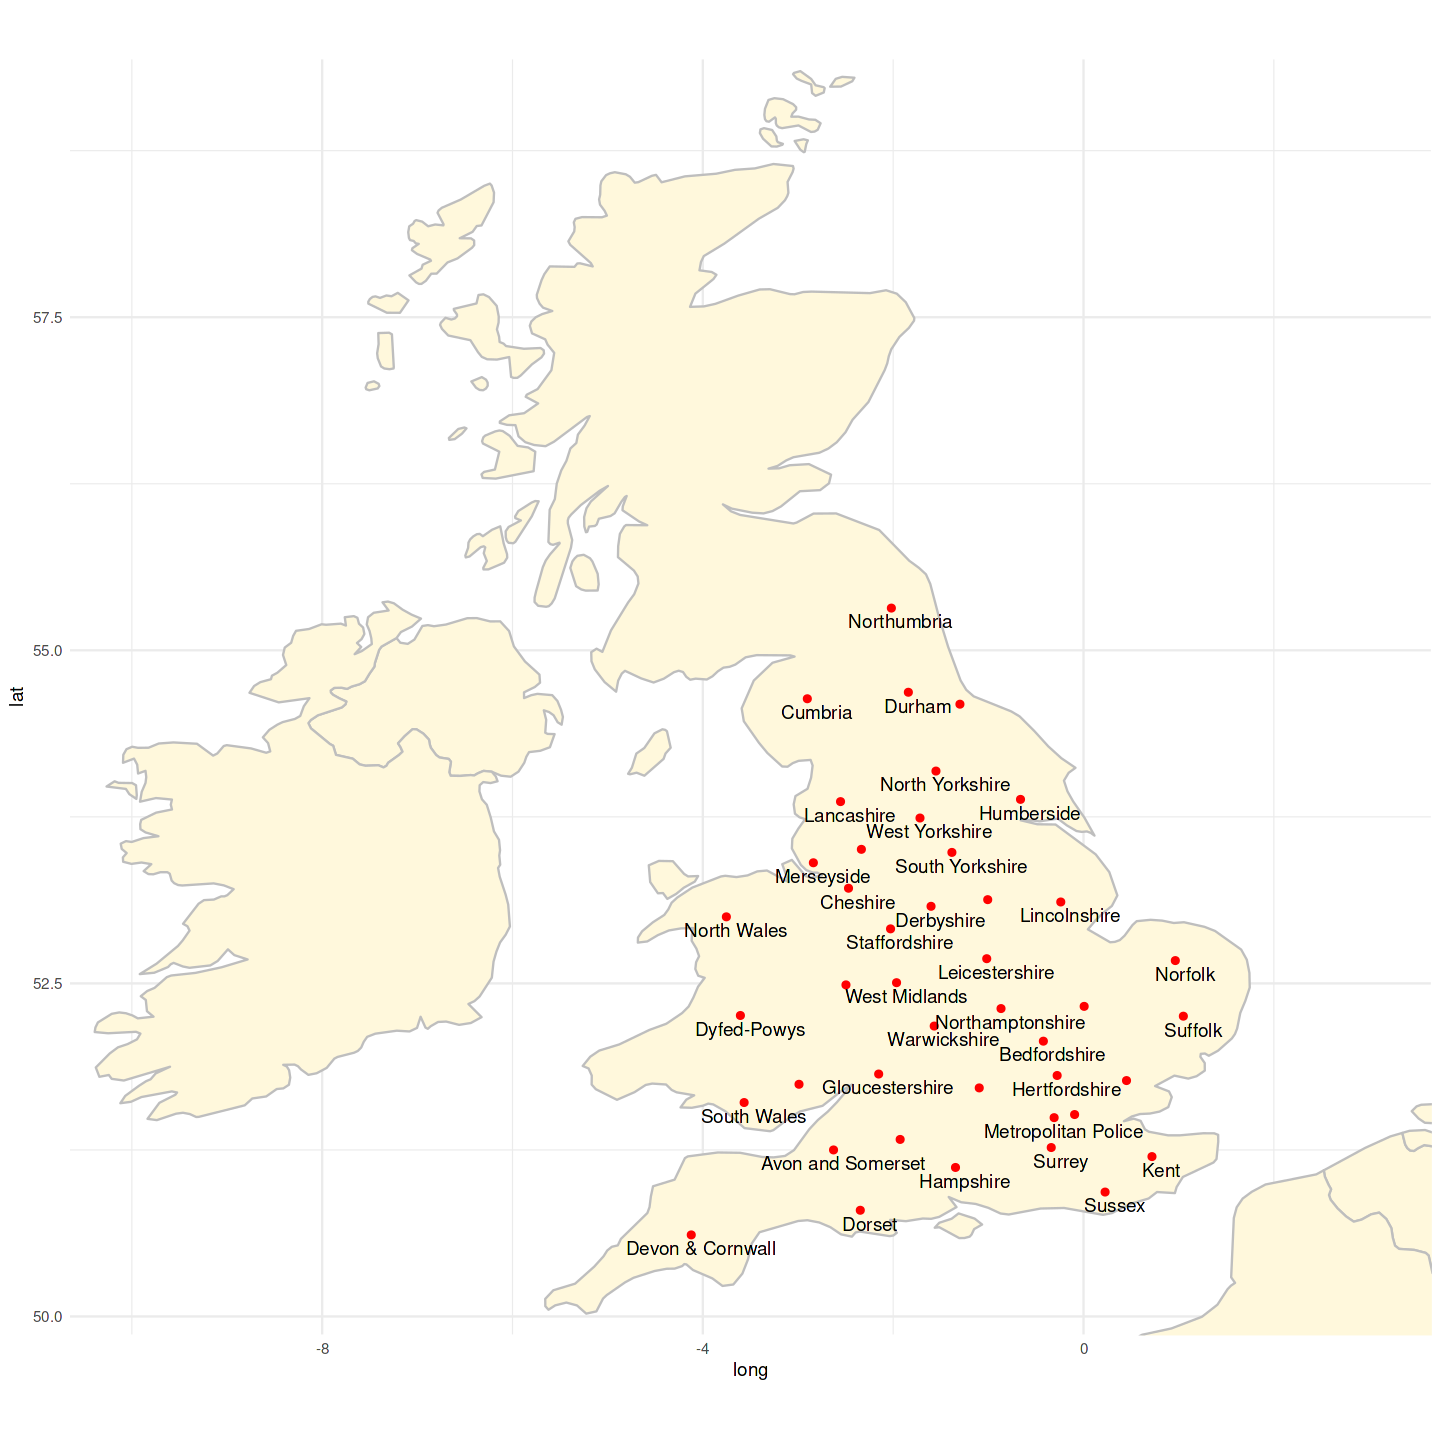

In [7]:
# Upload the UK police force areas locations
areas_locations <- janitor::clean_names(read_csv("/kaggle/input/uk-police-force-areas/Police_Force_Areas_(Dec_2021)_EW_BFE.csv"))
worldmap <- map_data('world')

# Make sure the graph is visible
options(repr.plot.width = 12, repr.plot.height = 12)

ggplot() + 
  geom_polygon(data = worldmap, aes(x = long, y = lat, group = group), fill = 'cornsilk', color = 'grey') +
  coord_fixed(ratio = 1.4, xlim = c(-10,3), ylim = c(50.3, 59)) +
  geom_point(data = areas_locations, mapping = aes(x = long, y = lat), colour = "red") +
  geom_text(data = areas_locations, mapping = aes(x = long, y = lat),
            label = areas_locations$pfa21nm, check_overlap = TRUE,
            nudge_x = .1, nudge_y = -.1) +
  theme_minimal()

We also notice that comma is used to separate thousands in the numeric columns, so let's fix that as it will mess up our calculations:

In [8]:
stop_and_search_raw[,9:11] <- sapply(stop_and_search_raw[,9:11], 
  function(v) {gsub("\\,","", as.character(v))})

glimpse(stop_and_search_raw)

Rows: 17,748
Columns: 13
$ measure                                <chr> "Number of stops and searches c…
$ time                                   <int> 2006, 2007, 2008, 2009, 2009, 2…
$ time_type                              <chr> "Financial year", "Financial ye…
$ ethnicity                              <chr> "All", "All", "All", "All", "Al…
$ ethnicity_type                         <chr> "All", "All", "All", "All", "Al…
$ legislation_type                       <chr> "All", "All", "All", "All", "Se…
$ geography                              <chr> "All - excluding BTP", "All - e…
$ geography_type                         <chr> "Police Force Area", "Police Fo…
$ number_of_stop_and_searches            <chr> "1037735", "1214693", "1495379"…
$ total_number_with_reported_ethnicity   <chr> "932065", "1125647", "1409802",…
$ population_by_ethnicity                <chr> "56075912", "56075912", "560759…
$ rate_per_1_000_population_by_ethnicity <chr> "18.51", "21.66", "26.67", "23.…
$ proportion_et

Let's have a look at how missing values are given in the data points, for example in the 'total number of stops' column:

In [9]:
test_column <- stop_and_search_raw$proportion_ethnicity_to_total_stops

# Write out all the offending strings
na_strings <- c("NA", "N A", "N / A", "N/A", "N/ A", "Not Available", "NOt available")

# Check how NA values are given
sum(grepl(paste(na_strings,collapse="|"), test_column), na.rm = FALSE) # Count the na_strings instances
sum(is.na(test_column), na.rm = FALSE) # Out of which given as 'NA' are
sum(is.null(test_column), na.rm = FALSE)

[1] 2151

[1] 160

[1] 0

Let's make sure all missing values are given as NA, rather than e.g. "N/A":

In [10]:
# Use the naniar library to replace na values
stop_and_search_raw <- naniar::replace_with_na_all(stop_and_search_raw, condition = ~.x %in% na_strings)

sum(is.na(stop_and_search_raw), na.rm = FALSE)

# Check whether it worked on our test column
test_column <- stop_and_search_raw$proportion_ethnicity_to_total_stops
sum(grepl(paste(na_strings,collapse="|"), test_column), na.rm = FALSE)
sum(is.na(test_column), na.rm = FALSE)

[1] 8327

[1] 0

[1] 2311

Value 2311 is the sum of 2151 and 160, so bingo! Finally, let's convert the final 5 columns to integer or decimal type respectively:

In [11]:
stop_and_search_raw <- stop_and_search_raw %>%
  mutate_at(c(9:11), as.integer, na.rm = FALSE) %>%
  mutate_at(c(12:13), as.numeric, na.rm = FALSE)

glimpse(stop_and_search_raw)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Rows: 17,748
Columns: 13
$ measure                                <chr> "Number of stops and searches c…
$ time                                   <int> 2006, 2007, 2008, 2009, 2009, 2…
$ time_type                              <chr> "Financial year", "Financial ye…
$ ethnicity                              <chr> "All", "All", "All", "All", "Al…
$ ethnicity_type                         <chr> "All", "All", "All", "All", "Al…
$ legislation_type                       <chr> "All", "All", "All", "All", "Se…
$ geography                              <chr> "All - excluding BTP", "All - e…
$ geography_type                         <chr> "Police Force Area", "Police Fo…
$ number_of_stop_and_searches            <int> 1037735, 1214693, 1495379, 1345…
$ total_number_with_reported_ethnicity   <int> 932065, 1125647, 1409802, 12841…
$ population_by_ethnicity                <int> 56075912, 56075912, 56075912, 5…
$ rate_per_1_000_population_by_ethnicity <dbl> 18.51, 21.66, 26.67, 23.99, 20.…
$ proportion_et

Data type conversion, completed!

<a id="section-remove"></a>
### 3.3. Removing columns we don't need

We'll now drop the columns we don't need, as those were determined [earlier](#section-col-spec):

In [12]:
stop_and_search <- stop_and_search_raw %>%
  select(-c(1,3,8))

glimpse(stop_and_search)

Rows: 17,748
Columns: 10
$ time                                   <int> 2006, 2007, 2008, 2009, 2009, 2…
$ ethnicity                              <chr> "All", "All", "All", "All", "Al…
$ ethnicity_type                         <chr> "All", "All", "All", "All", "Al…
$ legislation_type                       <chr> "All", "All", "All", "All", "Se…
$ geography                              <chr> "All - excluding BTP", "All - e…
$ number_of_stop_and_searches            <int> 1037735, 1214693, 1495379, 1345…
$ total_number_with_reported_ethnicity   <int> 932065, 1125647, 1409802, 12841…
$ population_by_ethnicity                <int> 56075912, 56075912, 56075912, 5…
$ rate_per_1_000_population_by_ethnicity <dbl> 18.51, 21.66, 26.67, 23.99, 20.…
$ proportion_ethnicity_to_total_stops    <dbl> NA, NA, NA, NA, NA, NA, NA, NA,…


<a id="section-replace"></a>
### 3.4. Replace missing values

To get an understanding of the number of missing values, we'll use the Amelia library:

Warning message:
“Unknown or uninitialised column: `arguments`.”
Warning message:
“Unknown or uninitialised column: `arguments`.”
Warning message:
“Unknown or uninitialised column: `imputations`.”


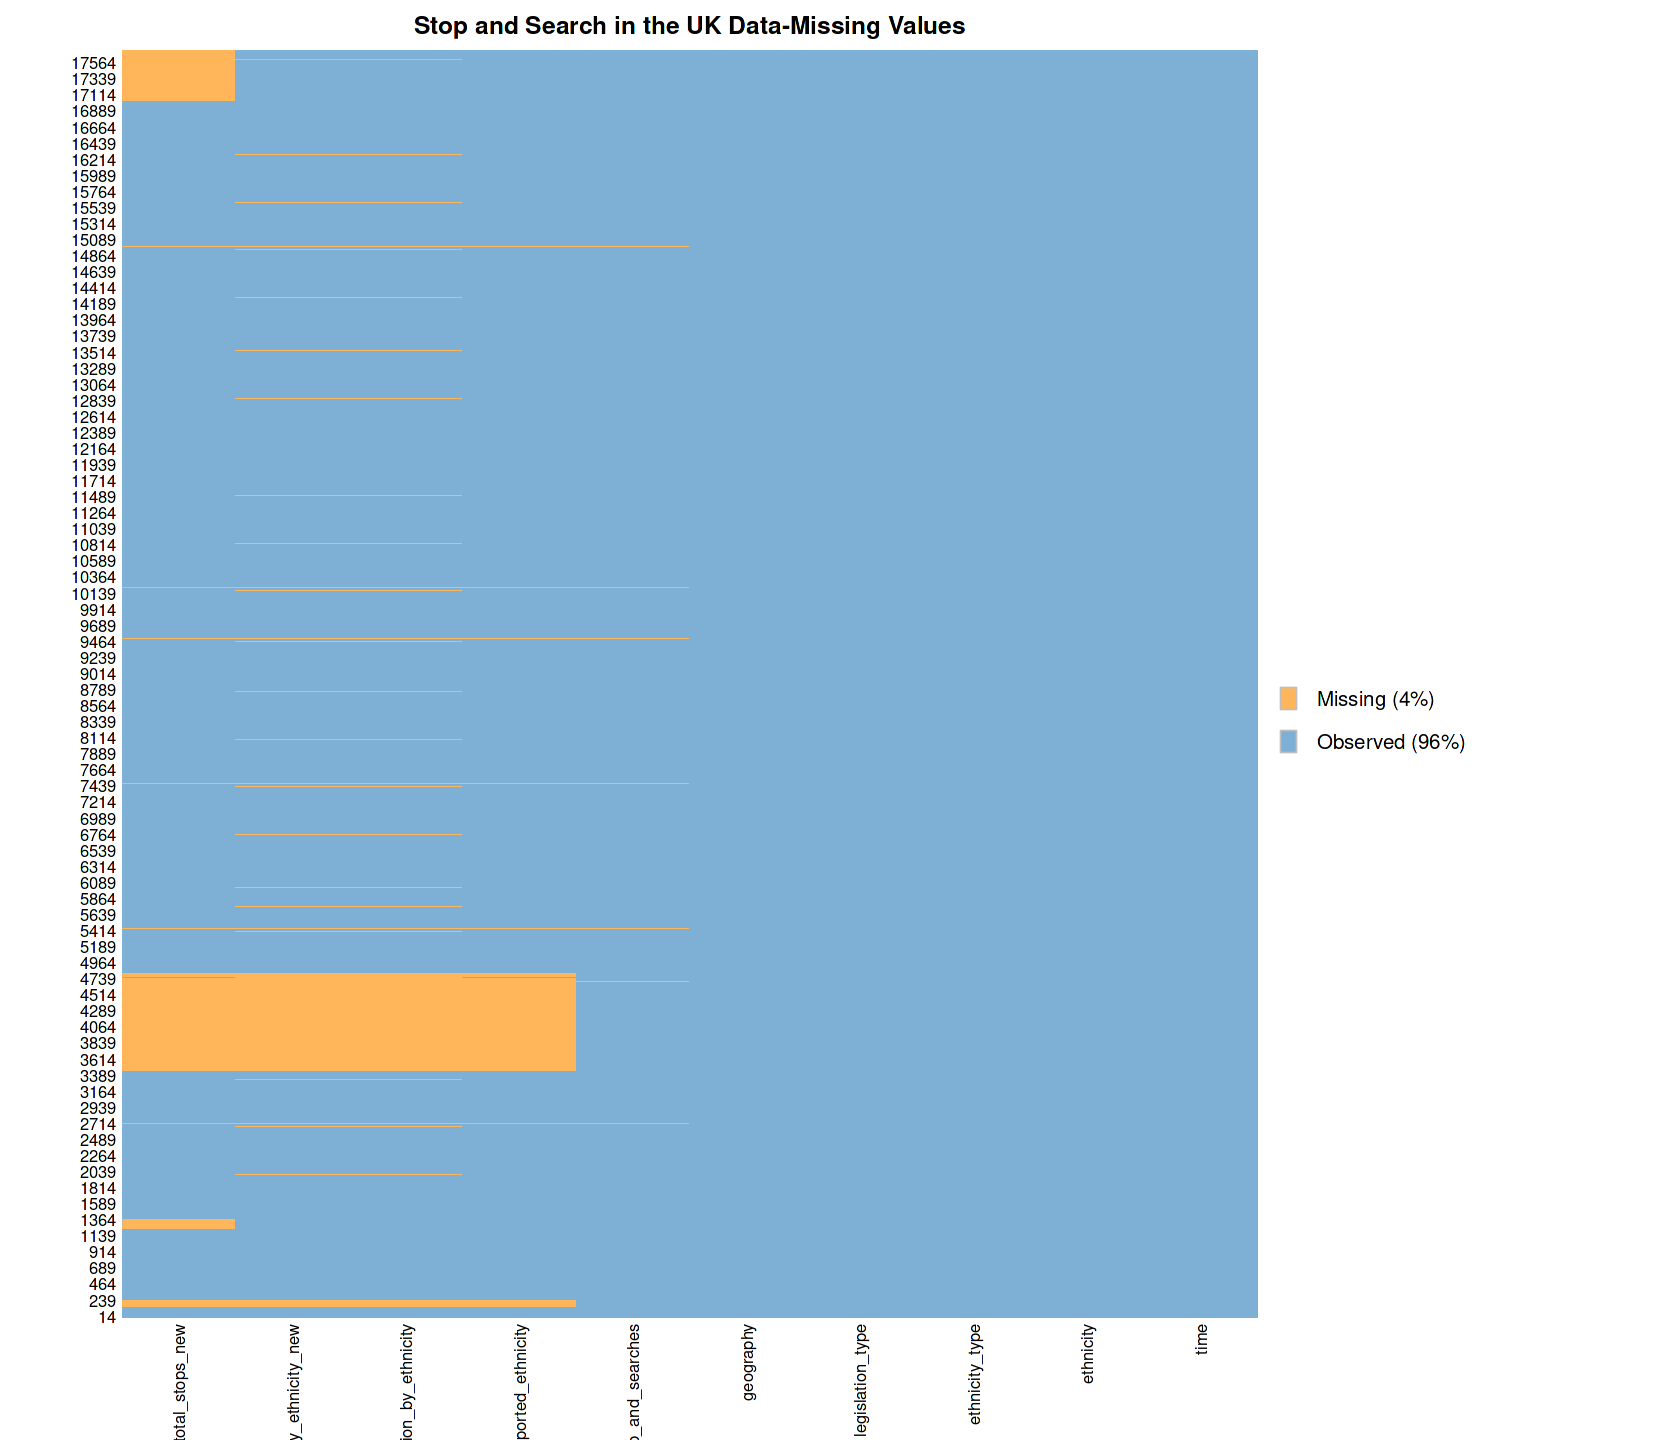

In [50]:
library(Amelia)
# Make sure the graph is visible enough
options(repr.plot.width = 14, repr.plot.height = 12)

missmap(stop_and_search, main="Stop and Search in the UK Data-Missing Values",col=c("#ffb55a","#7eb0d5"),legend=TRUE)

The graph makes sense: as the population by ethnicity is a prerequisite for calculating the rate per 1000 population, the latter should have at least the same NA as the former. The same applies to the total number of stops and the proportion of stops by ethnicity columns:

In [15]:
# NA, Population by ethnicity is missing =< NA, Rate per 1000 population

sum(is.na(stop_and_search$population_by_ethnicity))
sum(is.na(stop_and_search$rate_per_1_000_population_by_ethnicity))
sum(is.na(stop_and_search$population_by_ethnicity)) < sum(is.na(stop_and_search$rate_per_1_000_population_by_ethnicity))

# NA, Total number of stops and searches excl. unreported ethnicity =< NA, Proportion of ethnicity total stop to Total number of stops

sum(is.na(stop_and_search$total_number_with_reported_ethnicity))
sum(is.na(stop_and_search$proportion_ethnicity_to_total_stops))
sum(is.na(stop_and_search$total_number_with_reported_ethnicity)) < sum(is.na(stop_and_search_raw$proportion_ethnicity_to_total_stops))

[1] 2156

[1] 2408

[1] TRUE

[1] 1542

[1] 2311

[1] TRUE

Let's examine if we can replace some of the missing values. As the rate_per_1_000_population_by_ethnicity = number_of_stop_and_searches / population_by_ethnicity, we will filter out the cases where:
- number_of_stop_and_searches is NA
- population_by_ethnicity is NA

and see how many values are still NA in the rate_per_1_000_population_by_ethnicity column:

In [16]:
stop_and_search_test_na <- stop_and_search %>%
  filter(!is.na(number_of_stop_and_searches) & !is.na(population_by_ethnicity))

sum(is.na(stop_and_search_test_na$rate_per_1_000_population_by_ethnicity))

[1] 252

So it looks like we can add a missing 252 values to our dataset. Let's do it:

In [17]:
# Create a new column to calculate the rate per 1000 of population by ethnicity
stop_and_search <- stop_and_search %>%
  mutate(rate_per_1_000_population_by_ethnicity_new = round(number_of_stop_and_searches / population_by_ethnicity * 1000, 2))

# How many NA values were filled-in?
sum(is.na(stop_and_search$rate_per_1_000_population_by_ethnicity)) - sum(is.na(stop_and_search$rate_per_1_000_population_by_ethnicity_new)) 

head(stop_and_search) %>%
  select(c(ncol(stop_and_search),ncol(stop_and_search)-2))

[1] 252

rate_per_1_000_population_by_ethnicity_new,rate_per_1_000_population_by_ethnicity
<dbl>,<dbl>
18.51,18.51
21.66,21.66
26.67,26.67
23.99,23.99
20.85,20.85
1.52,1.83


Interestingly enough, we notice that in some cases the rates in the rate_per_1_000_population_by_ethnicity column differ from the new rate column. As the latter has just been calculated, some of the initial data provided wasn't correct! We'll find out how many these cases are:

In [18]:
# Calculate the number of different values between the two columns

sum(stop_and_search$rate_per_1_000_population_by_ethnicity_new != stop_and_search$rate_per_1_000_population_by_ethnicity, na.rm=TRUE)

[1] 1011

Let's apply the same process to the total number of stops and the proportion of stops by ethnicity columns:

In [19]:
# Find out how many na values can be calculated
stop_and_search_test_na <- stop_and_search %>%
  filter(!is.na(number_of_stop_and_searches) & !is.na(total_number_with_reported_ethnicity))

sum(is.na(stop_and_search_test_na$proportion_ethnicity_to_total_stops))

[1] 769

However, the number_of_stop_and_searches column of our dataset includes entries for stop and searches where the ethnicity wasn't reported. In those cases, the ratio of (number of stops and searches) / (total number with reported ethnicity) will exceed 1. This only applies when the ethnicity metric equals 'All' (which makes sense), as we demonstrate below:

In [20]:
# Create a new column to calculate the proportion of total stops by ethnicity to the total stops, excluding unreported
stop_and_search <- stop_and_search %>%
  mutate(proportion_ethnicity_to_total_stops_new = round(number_of_stop_and_searches / total_number_with_reported_ethnicity * 100, 2))

head(stop_and_search[order(-stop_and_search$proportion_ethnicity_to_total_stops_new),]) %>%
  filter(proportion_ethnicity_to_total_stops_new > 100) %>%
  select(c(ethnicity, geography, proportion_ethnicity_to_total_stops_new))

ethnicity,geography,proportion_ethnicity_to_total_stops_new
<chr>,<chr>,<dbl>
All,"London, City of",175.28
All,Avon & Somerset,165.94
All,Humberside,154.53
All,Merseyside,153.98
All,Cheshire,152.77
All,"London, City of",152.44


So let's assign the NA value to the proportion column in those cases:

In [21]:
# Re-calculate the new proportion column, excluding data points where ethnicity = 'All'
stop_and_search <- stop_and_search %>%
  mutate(proportion_ethnicity_to_total_stops_new = ifelse(ethnicity == 'All', NA,
    round(number_of_stop_and_searches / total_number_with_reported_ethnicity * 100, 2)))

# How many NA values were filled in?
sum(is.na(stop_and_search$proportion_ethnicity_to_total_stops)) - sum(is.na(stop_and_search$proportion_ethnicity_to_total_stops_new)) 

[1] -2

The negative value here means that we filled-in two additional data points were a value rather than NA was in place. Let's drop the older columns we no longer need:

In [22]:
stop_and_search <- stop_and_search %>%
  select(-c(rate_per_1_000_population_by_ethnicity, proportion_ethnicity_to_total_stops))

glimpse(stop_and_search)

Rows: 17,748
Columns: 10
$ time                                       <int> 2006, 2007, 2008, 2009, 200…
$ ethnicity                                  <chr> "All", "All", "All", "All",…
$ ethnicity_type                             <chr> "All", "All", "All", "All",…
$ legislation_type                           <chr> "All", "All", "All", "All",…
$ geography                                  <chr> "All - excluding BTP", "All…
$ number_of_stop_and_searches                <int> 1037735, 1214693, 1495379, …
$ total_number_with_reported_ethnicity       <int> 932065, 1125647, 1409802, 1…
$ population_by_ethnicity                    <int> 56075912, 56075912, 5607591…
$ rate_per_1_000_population_by_ethnicity_new <dbl> 18.51, 21.66, 26.67, 23.99,…
$ proportion_ethnicity_to_total_stops_new    <dbl> NA, NA, NA, NA, NA, NA, NA,…


<a id="section-outliers"></a>
### 3.5. Check for outliers

Outliers are observations that lie at an abnormal distance from other values in a random sample from a population, i.e. they are extreme values that stand out greatly from the overall pattern of values in a dataset. This is a general definition, that allows us to determine whether a value is an outlier or not. To help us decide, we will:
1. Examine of the overall shape of the data points for important features, including symmetry and departures from assumptions. 
2. Examine specific data points that are far removed from the mass of data.  

The box plot is a useful graphical display for describing the behavior of the data in the middle as well as at the ends of the distributions. It uses the median and the lower and upper quartiles (defined as the 25th and 75th percentiles) and is constructed by drawing a box between the upper and lower quartiles with a solid line drawn across the box to locate the median.

Warning message:
“Removed 2156 rows containing non-finite values (`stat_boxplot()`).”


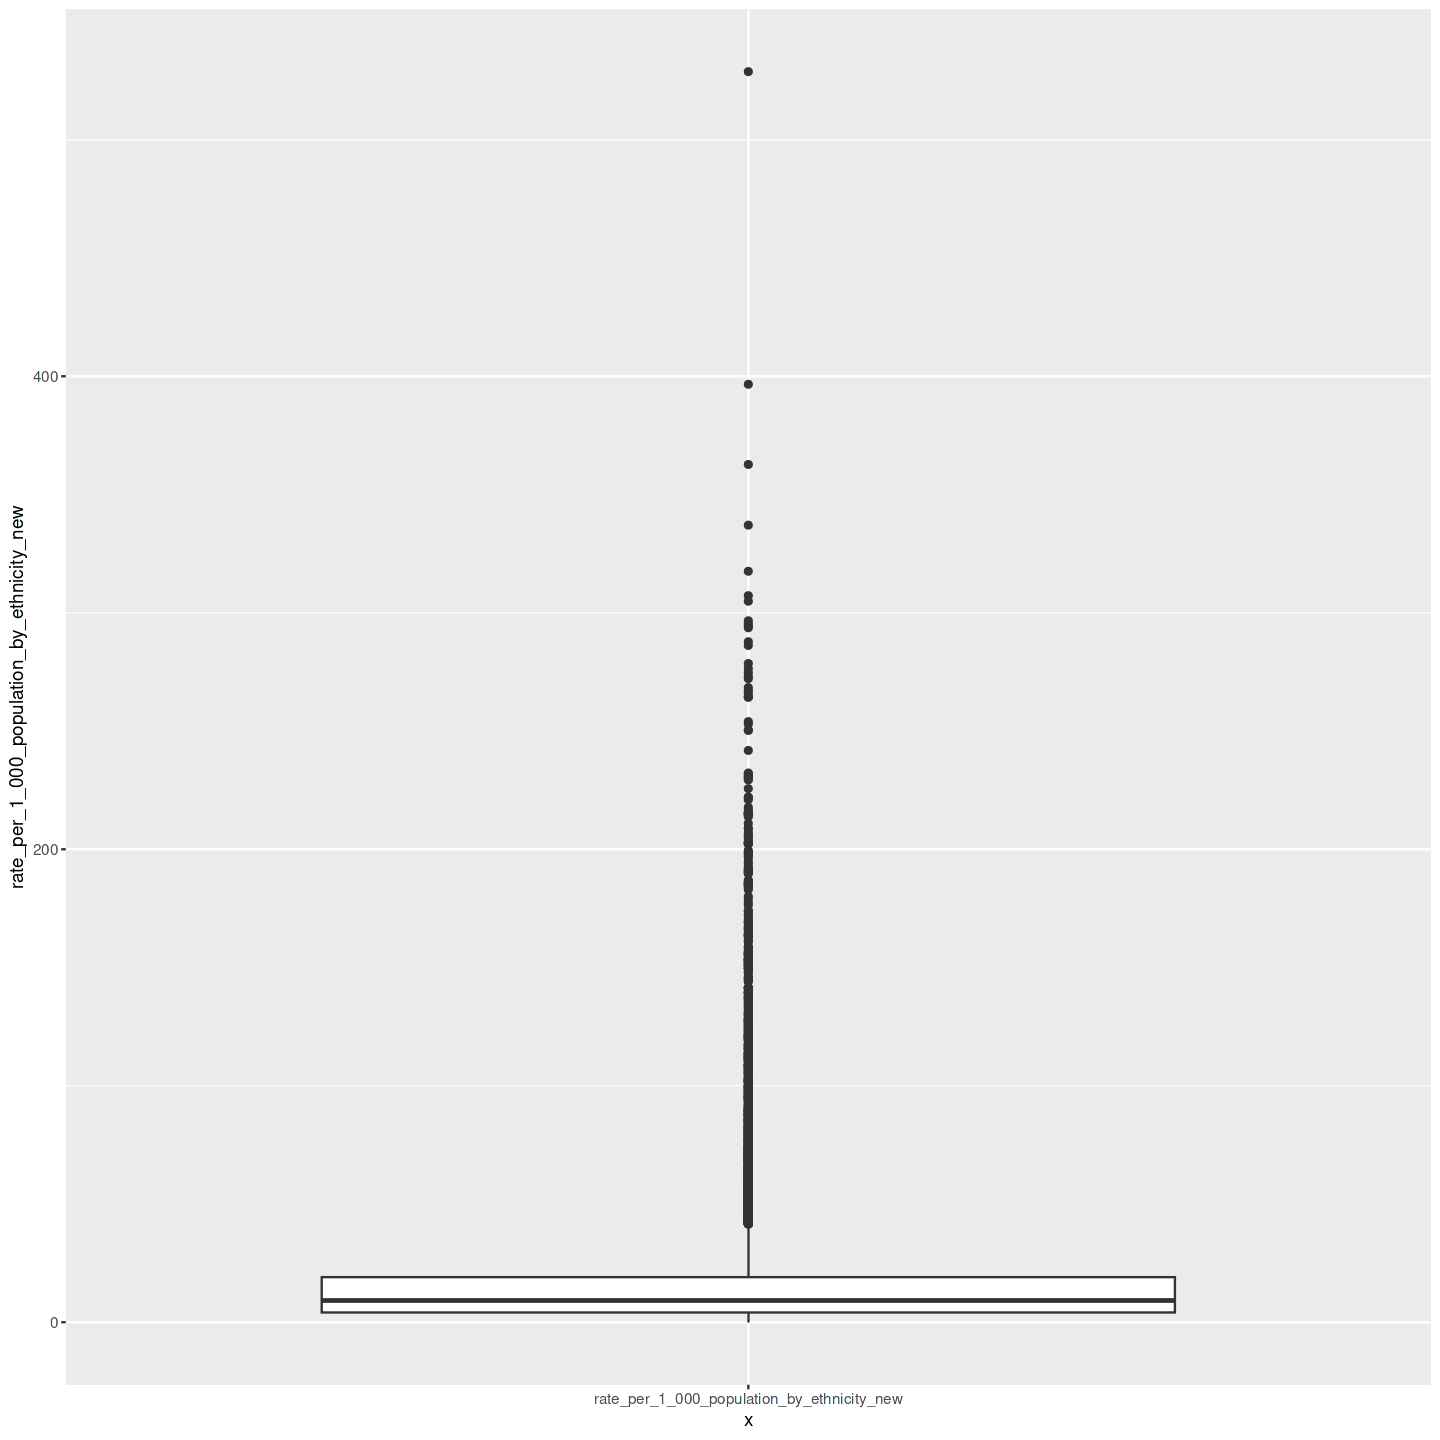

In [23]:
# use a box plot to see if we have outliers in the rate_per_1_000_population_by_ethnicity_new column of the dataset
ggplot(stop_and_search, aes(x = "rate_per_1_000_population_by_ethnicity_new", rate_per_1_000_population_by_ethnicity_new)) +
    geom_boxplot()

Warning message:
“Removed 2156 rows containing non-finite values (`stat_boxplot()`).”


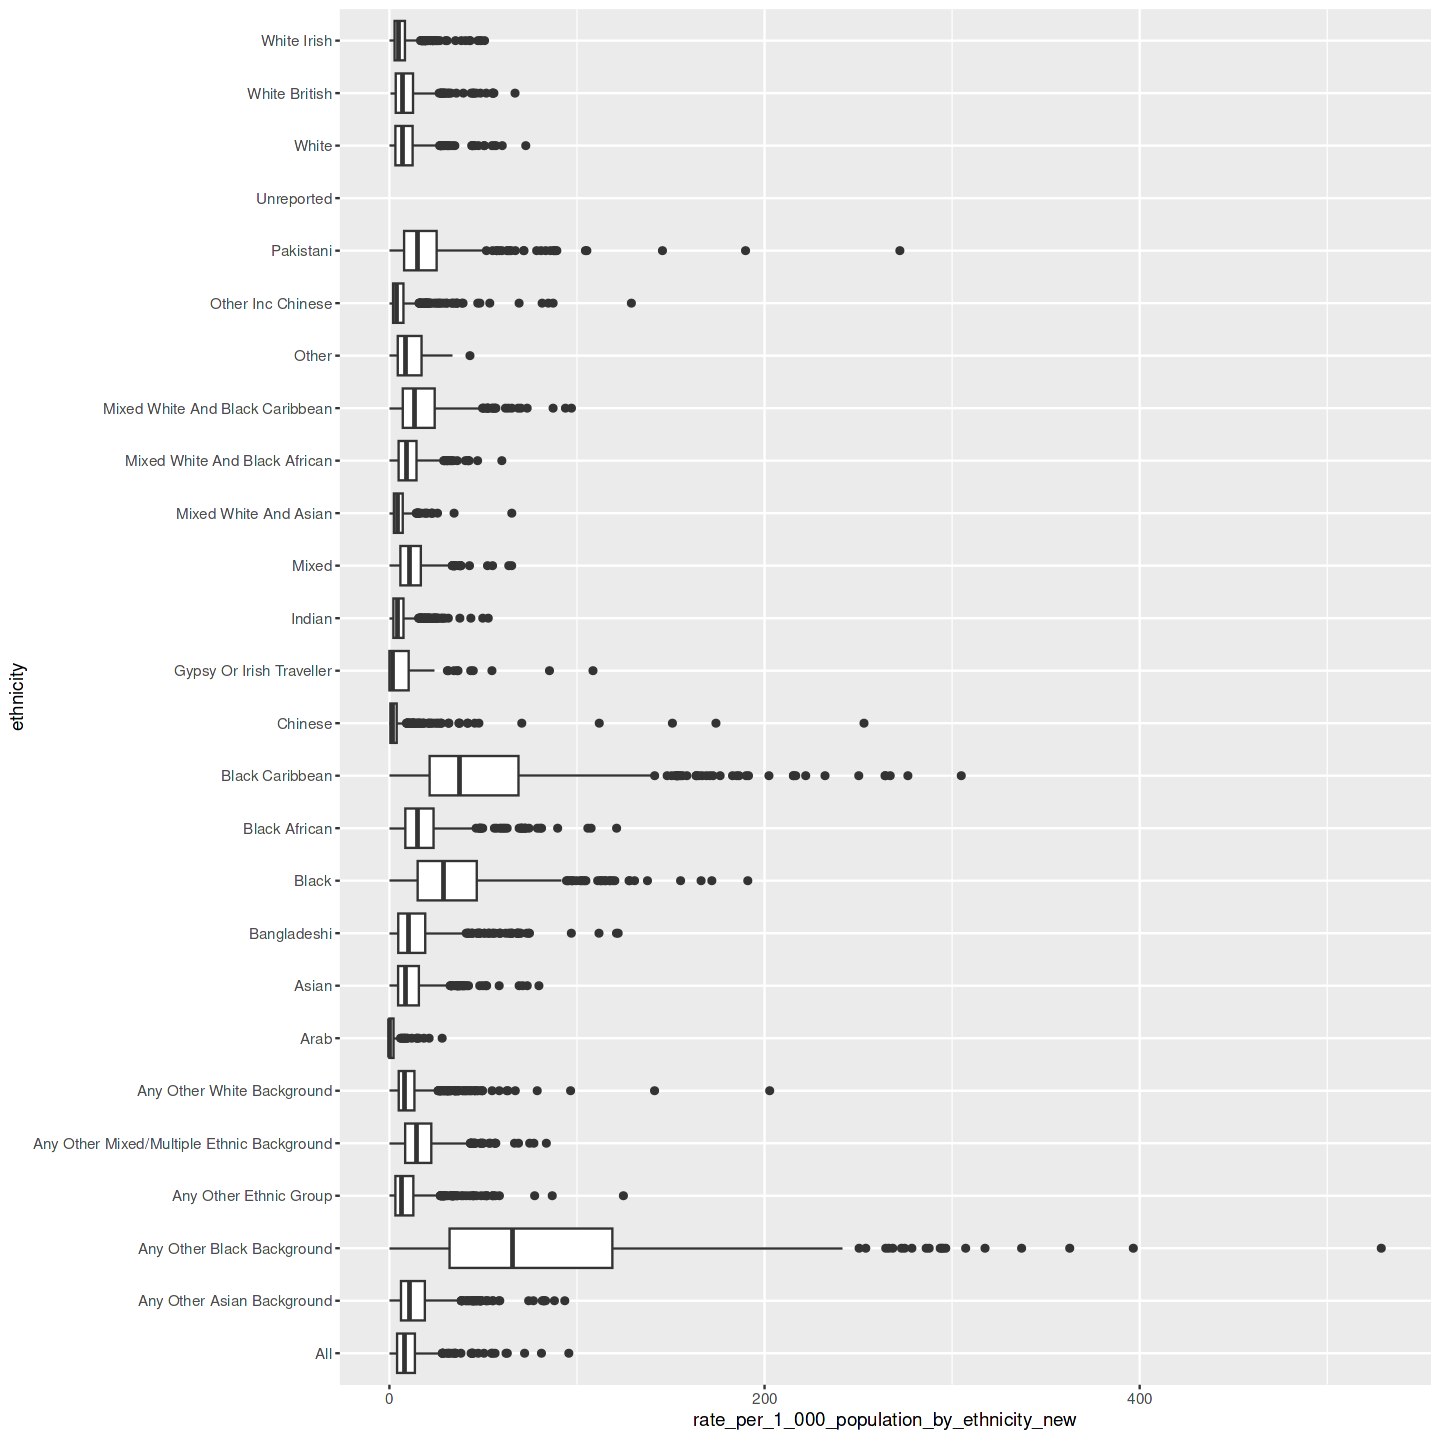

In [24]:
# look for outliers for each ethnicity
ggplot(stop_and_search, aes(ethnicity, rate_per_1_000_population_by_ethnicity_new)) +
    geom_boxplot() +
    coord_flip() # flip our plot so the labels are easier to read

Let's have a look at the top 5 ethnicites regarding the number of stop and searches. Since simply summarizing by mean will treat each instance as isobaric (e.g. the mean in Manchester and Northumbria will be averaged, whereas their populations differ significantly), we will use the totals provided in the 'All - including BTP' category:

In [25]:
# See the top 5 ethnicities to be stopped and searched
stop_and_search_sum_rate <- stop_and_search %>% 
  group_by(ethnicity) %>% 
  filter(geography == 'All - including BTP') %>% 
  summarize(mean_rate=mean(rate_per_1_000_population_by_ethnicity_new, na.rm = TRUE)) %>%
  arrange(desc(mean_rate)) 

head(stop_and_search_sum_rate)
tail(stop_and_search_sum_rate)

ethnicity,mean_rate
<chr>,<dbl>
Any Other Black Background,128.37250
Black Caribbean,63.68833
Black African,37.23167
Bangladeshi,32.65417
Black,30.90700
Any Other Asian Background,28.51083


ethnicity,mean_rate
<chr>,<dbl>
Mixed White And Asian,6.094167
Other Inc Chinese,5.455769
White,4.898000
Chinese,4.088333
Arab,1.285000
Unreported,NaN


So the top ethnicities to be stopped and searched in the UK are Any Other Black Background (128 per 1000 people), Black Caribbean (64), Black African (37), Bangladeshi (33) and Black (31). The bottow 5 include White (5.5), Chinese (4.1) and Arab (1.3). 

Warning message:
“Removed 2156 rows containing missing values (`geom_point()`).”


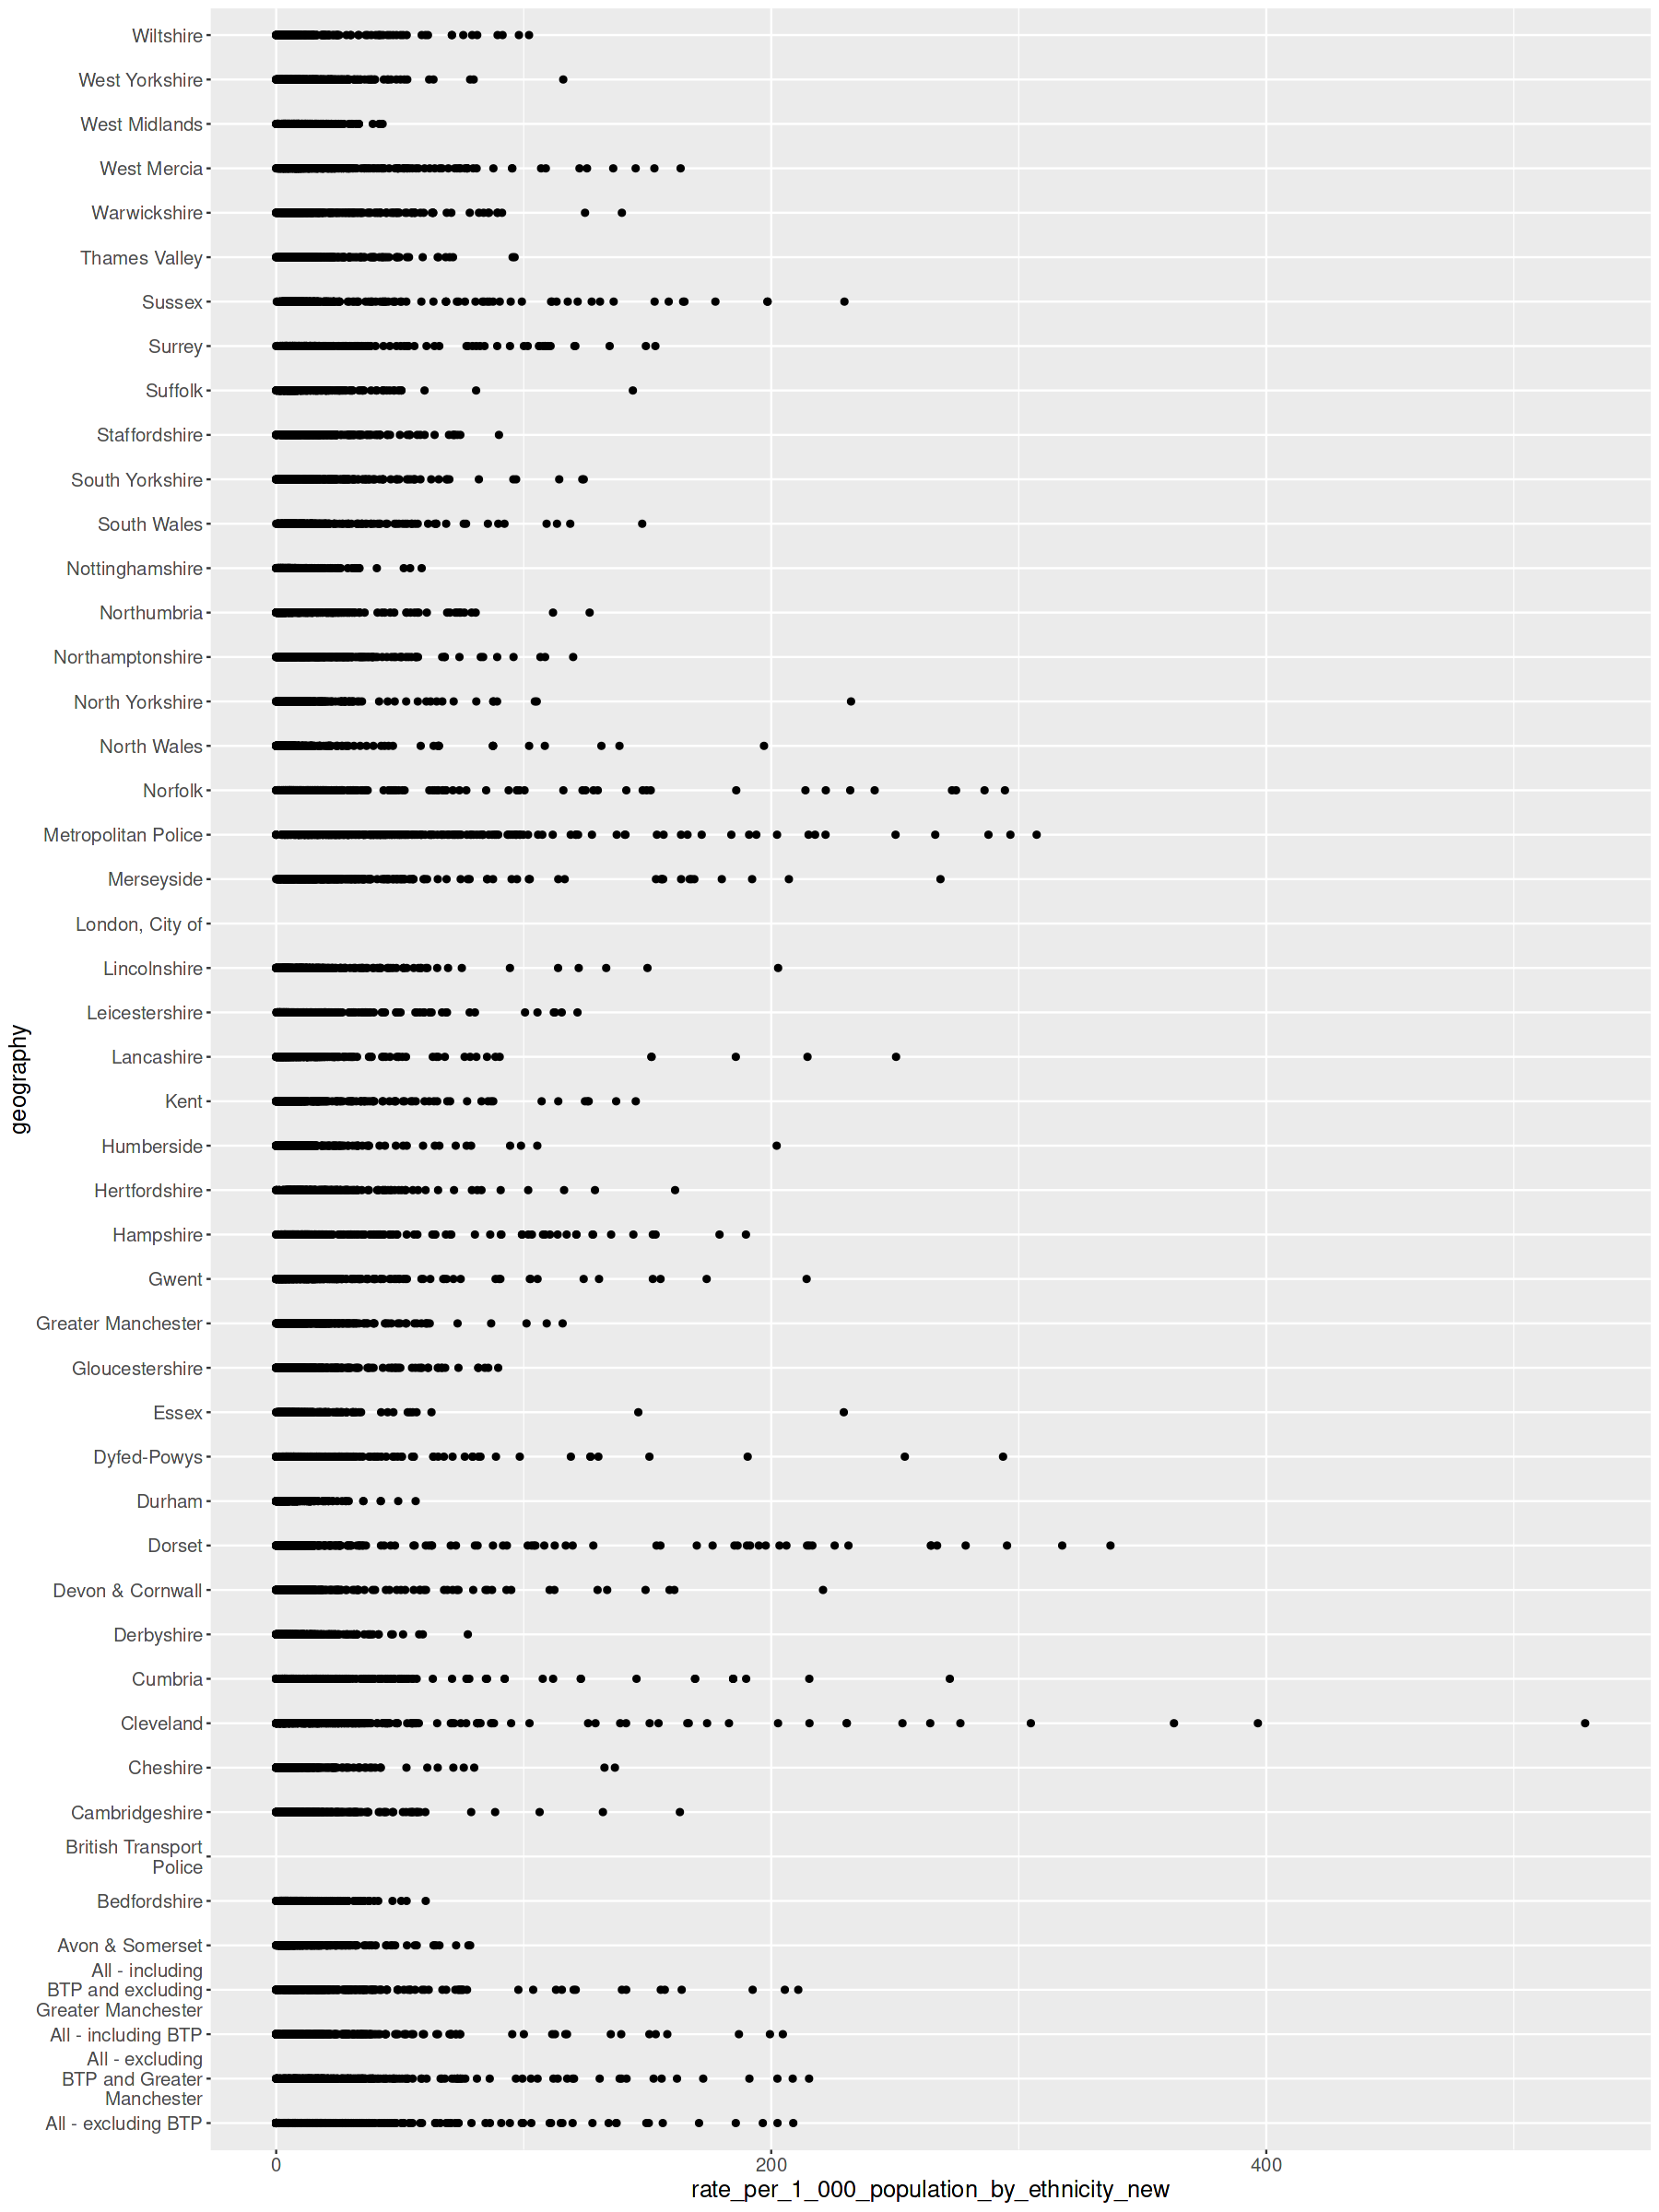

In [26]:
# Make sure the graph is visible enough
options(repr.plot.width = 15, repr.plot.height = 20) 

# look for outliers for each location
ggplot(stop_and_search, aes(geography, rate_per_1_000_population_by_ethnicity_new)) +
    geom_point() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 20, whitespace_only = FALSE)) + # Wrap labels 
    theme(text = element_text(size = 15)) + 
    coord_flip() #flip x & y axis and reverse the x axis

Going through the graph, it seems that in Cleveland, Yorkshire, there have been years where the stop and searches for Any Other Black Background ethnicities reached or exceeded 400 per 1000 ethnicity population. Are those outliers? Let's have a closer look:

In [27]:
# Top 10 highest values by geography

data_new2 <- stop_and_search %>% 
  filter(!grepl('All', geography)) %>% 
  arrange(desc(rate_per_1_000_population_by_ethnicity_new)) 

head(data_new2, 10)

time,ethnicity,ethnicity_type,legislation_type,geography,number_of_stop_and_searches,total_number_with_reported_ethnicity,population_by_ethnicity,rate_per_1_000_population_by_ethnicity_new,proportion_ethnicity_to_total_stops_new
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
2012,Any Other Black Background,ONS 2001 16+1,All,Cleveland,156,31104,295,528.81,0.50
2013,Any Other Black Background,ONS 2001 16+1,All,Cleveland,117,24616,295,396.61,0.48
2011,Any Other Black Background,ONS 2001 16+1,All,Cleveland,107,30424,295,362.71,0.35
2013,Any Other Black Background,ONS 2001 16+1,All,Dorset,121,8329,359,337.05,1.45
2007,Any Other Black Background,ONS 2001 16+1,All,Dorset,114,7786,359,317.55,1.46
2008,Any Other Black Background,ONS 2001 16+1,All,Metropolitan Police,52249,721451,170063,307.23,7.24
2010,Black Caribbean,ONS 2001 16+1,All,Cleveland,75,29911,246,304.88,0.25
2010,Any Other Black Background,ONS 2001 16+1,All,Metropolitan Police,50444,560544,170063,296.62,9.00
2015,Any Other Black Background,ONS 2001 16+1,All,Dorset,106,4278,359,295.26,2.48


From the above, we conclude that regions with relatively small populations (appr. 125 to 600 people) of an ethnicity group (Black background, Black Caribbean) have high rates of stop and searches within a year (37 to 180 respectively). Since these are small populations, unusual rates can occur, which might indicate either police bias and/or a criminal history of such a group that lead to them; but most likely wrong data entry can be excluded. 

We also notice that the City of London values are missing, while the Greater London values are given under the 'Metropolitan Police' label:

> **The Metropolitan Police** is the service for the Greater London area, (excluding City of London) and its 8.6 million residents. 

Upon inspection, we realise that the reason is that the Population by ethnicity column is missing for the city of London:

In [28]:
stop_and_search %>%
  filter(geography == 'London, City of') %>%
  {unique(.$population_by_ethnicity)}

[1] NA

As London is UK's capital and largest city, this is an important deficiency. This data is available for 2021 on [data.gov.uk](https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/regional-ethnic-diversity/latest#download-the-data) and we will use it as rough approximates to fill in the missing values for 2019 in our table. First, let's inspect the column entries and make sure that the naming of ethnicities agree:

In [29]:
# Upload the UK population dataset
london_population <- janitor::clean_names(read_csv("/kaggle/input/uk-local-authority-ethnic-diversity-2021/population-by-ethnicity-and-local-authority-2021 (1).csv"))

# Keep only London values
london_population <- london_population %>%
  filter(geography == 'City of London')

# Find the differences between the values of the ethnicity columns in both datasets
setdiff(london_population$ethnicity, stop_and_search$ethnicity)
setdiff(stop_and_search$ethnicity, london_population$ethnicity)

Rows: 8300 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Measure, Source, Geography, Geography_code, Ethnicity, Ethnicity_ty...
dbl (6): Time, Ethnic Population, Local Authority Population, Total Ethnic P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Roma"                        "Any Other Ethnic Background"

[1] "Any Other Ethnic Group" "Other Inc Chinese"      "Unreported"

The results show that the 'other ethnic group' category is presented under a different name. Let's fix that:

In [30]:
# Replace matching entries
london_population$ethnicity <- str_replace(london_population$ethnicity, "Any Other Ethnic Background", "Any Other Ethnic Group")

# Check for remaining differences between the values
setdiff(london_population$ethnicity, stop_and_search$ethnicity)
setdiff(stop_and_search$ethnicity, london_population$ethnicity)

[1] "Roma"

[1] "Other Inc Chinese" "Unreported"

And now we can join our datasets and add the missing values for London:

In [31]:
# Join the datasets
stop_and_search <- stop_and_search %>%
  left_join(london_population %>% select(ethnic_population, ethnicity), by="ethnicity") 

# Add the London values
stop_and_search <- stop_and_search %>%
  mutate(population_by_ethnicity = case_when(stop_and_search$geography == 'London, City of' ~ 
    ethnic_population, TRUE ~ as.numeric(as.character(population_by_ethnicity))))

And now we'll repeat the calculations for rate_per_1_000_population_by_ethnicity and proportion_ethnicity_to_total_stops, only for the London data points:

In [32]:
# Calculate the rate to 1000 people
stop_and_search <- stop_and_search %>%
  mutate(rate_per_1_000_population_by_ethnicity_new = case_when(stop_and_search$geography == 'London, City of' ~ 
  round(stop_and_search$number_of_stop_and_searches / stop_and_search$population_by_ethnicity * 1000, 2), TRUE ~ as.numeric(as.character(rate_per_1_000_population_by_ethnicity_new))))

In [33]:
# Calculate the ethnicity to total proportion
stop_and_search <- stop_and_search %>%
  mutate(proportion_ethnicity_to_total_stops_new = case_when(stop_and_search$geography == 'London, City of' &  ethnicity != 'All' ~
  round(number_of_stop_and_searches / total_number_with_reported_ethnicity * 100, 2), TRUE ~ as.numeric(as.character(proportion_ethnicity_to_total_stops_new))))

In [34]:
# Omit the columns we no longer need
stop_and_search <- stop_and_search %>%
  select(-ethnic_population)

<a id="section-dupl"></a>
### 3.6. Duplicates

To plot duplicates, I'm first going to create a dataframe with 1) a logical vector indicating whether or not a specific row is duplicated elsewhere in the dataset and 2) a numeric vector of the index of each row. (I'm not using row numbers because if you're using the Tidyverse version of a dataframe, they get removed whenever you manipulate the dataframe.) Then, I'm going to plot that information so that each duplicated row shows up as a black line. Like so:

In [35]:
# get the row numbers of duplicated rows and create a tibble
duplicated_rows <- tibble(duplicated = duplicated(stop_and_search), row = 1:nrow(stop_and_search)) %>%
    filter(duplicated == T)

stop_and_search[duplicated_rows$row,]

# So let's remove them
stop_and_search <- unique(stop_and_search)

duplicated_rows <- tibble(duplicated = duplicated(stop_and_search), row = 1:nrow(stop_and_search)) %>%
    filter(duplicated == T)
nrow(duplicated_rows) # check for remaining duplicates

time,ethnicity,ethnicity_type,legislation_type,geography,number_of_stop_and_searches,total_number_with_reported_ethnicity,population_by_ethnicity,rate_per_1_000_population_by_ethnicity_new,proportion_ethnicity_to_total_stops_new
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
2014,Asian,ONS 2001 5+1,Section 60,All - including BTP,82,498721,3820390,0.02,0.02
2014,Black,ONS 2001 5+1,Section 60,All - including BTP,172,498721,1864890,0.09,0.03
2014,Mixed,ONS 2001 5+1,Section 60,All - including BTP,39,498721,1224400,0.03,0.01
2014,Other Inc Chinese,ONS 2001 5+1,Section 60,All - including BTP,13,498721,956837,0.01,0.00


[1] 0

<a id="section-viz"></a>
## 4. Data Analysis and Visualization

Let's have a look at the regions that have the most stop and searches per 1000 persons, according to the latest data (2019). We'll start by uploading the Police Force Areas shape files:

In [36]:
# Load the sf library in order to read the shape file
library(sf)

shp <- st_read('/kaggle/input/uk-police-force-areas-2021/Police_Force_Areas_(Dec_2021)_EW_BGC.shp')

shp_country_borders <- st_read('/kaggle/input/uk-borders-shapefiles/CTRY_DEC_2022_UK_BUC.shp')

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE



Reading layer `Police_Force_Areas_(Dec_2021)_EW_BGC' from data source 
  `/kaggle/input/uk-police-force-areas-2021/Police_Force_Areas_(Dec_2021)_EW_BGC.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 43 features and 10 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 82668.52 ymin: 5352.6 xmax: 655653.8 ymax: 657540.4
Projected CRS: OSGB 1936 / British National Grid
Reading layer `CTRY_DEC_2022_UK_BUC' from data source 
  `/kaggle/input/uk-borders-shapefiles/CTRY_DEC_2022_UK_BUC.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 11 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -116.1928 ymin: 7054.1 xmax: 655653.8 ymax: 1220310
Projected CRS: OSGB 1936 / British National Grid


Let's check that locations are provided in the same way in both datasets and correct any discrepances:

In [37]:
# Check whether Police Force Areas are give with different names in the two datasets
setdiff(shp$PFA21NM, stop_and_search$geography)

# Correct that
shp$PFA21NM <- str_replace(shp$PFA21NM, 'Avon and Somerset', 'Avon & Somerset')

# Check if successful
setdiff(shp$PFA21NM, stop_and_search$geography)

[1] "Avon and Somerset"

character(0)

In [38]:
counties_rate_plot <- stop_and_search %>% 
  filter(ethnicity == 'All' & !grepl(c('All'), geography) & time == '2019') %>%
  right_join(shp, by = c("geography" = "PFA21NM")) 

And a quick look at our results prior to visualizing:

In [39]:
head(counties_rate_plot[order(-counties_rate_plot$rate_per_1_000_population_by_ethnicity_new),]) %>%
  select(c(ethnicity, geography, rate_per_1_000_population_by_ethnicity_new))

ethnicity,geography,rate_per_1_000_population_by_ethnicity_new
<chr>,<chr>,<dbl>
All,"London, City of",342.73
All,Metropolitan Police,33.74
All,Merseyside,24.63
All,Essex,11.61
All,South Yorkshire,11.03
All,South Wales,10.09


We notice that the rate in the city of London is an outlier. This can be explained by the fact that it comprises mostly office spaces (hence low number of resident population, the denominator of the ratio), it has increased security concerns as a major tourist destination and home of UK politics venues (hence the high number of stops and searches, the numerator of the ratio). We will take this difference into account in our plot further down.

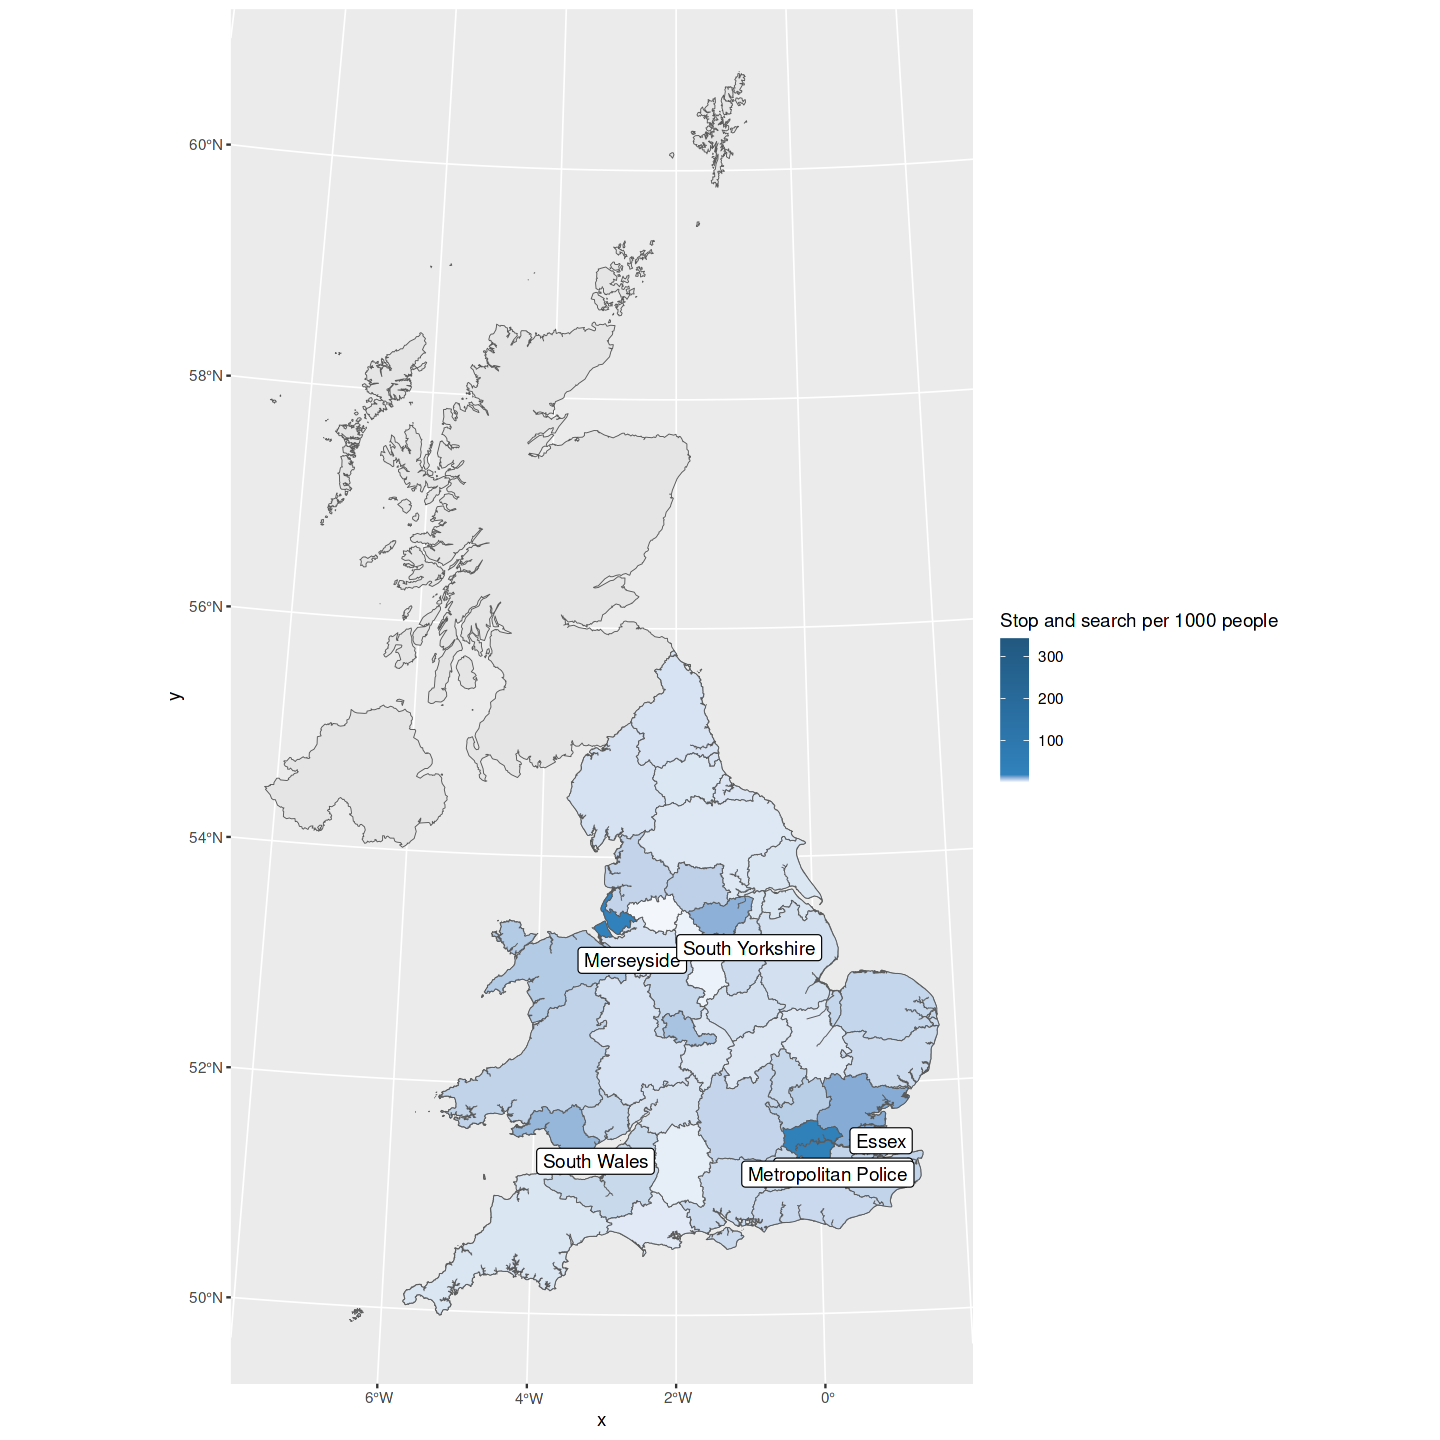

In [40]:
# Make the graph visible

options(repr.plot.width = 12, repr.plot.height = 12)

ggplot() +
  geom_sf(shp_country_borders,
    mapping = aes(geometry = geometry)) +
  geom_sf(counties_rate_plot,
    mapping = aes(geometry = geometry,
    fill = rate_per_1_000_population_by_ethnicity_new)) +
  geom_sf_label(counties_rate_plot %>% 
                slice_max(rate_per_1_000_population_by_ethnicity_new, n = 6),
    mapping = aes(geometry = geometry, label = geography),
      nudge_x = 30000, nudge_y = -30000) + 
  scale_colour_gradientn(
    colours = c("#f3f7fc","#3182bd","#215880"),
    values = scales::rescale(c(0, 0.05, 1)),
    space = "Lab",
    na.value = "grey50",
    guide = "colourbar",
    aesthetics = "fill",
    name='Stop and search per 1000 people'
  )  

The maps shows that the UK areas where most stop and searches take place are:
1. Greater London - City of London
2. Merseyside 
3. Essex
4. South Yorkshire
5. South Wales

How has the total number of stop and searches fluctuated over the years?

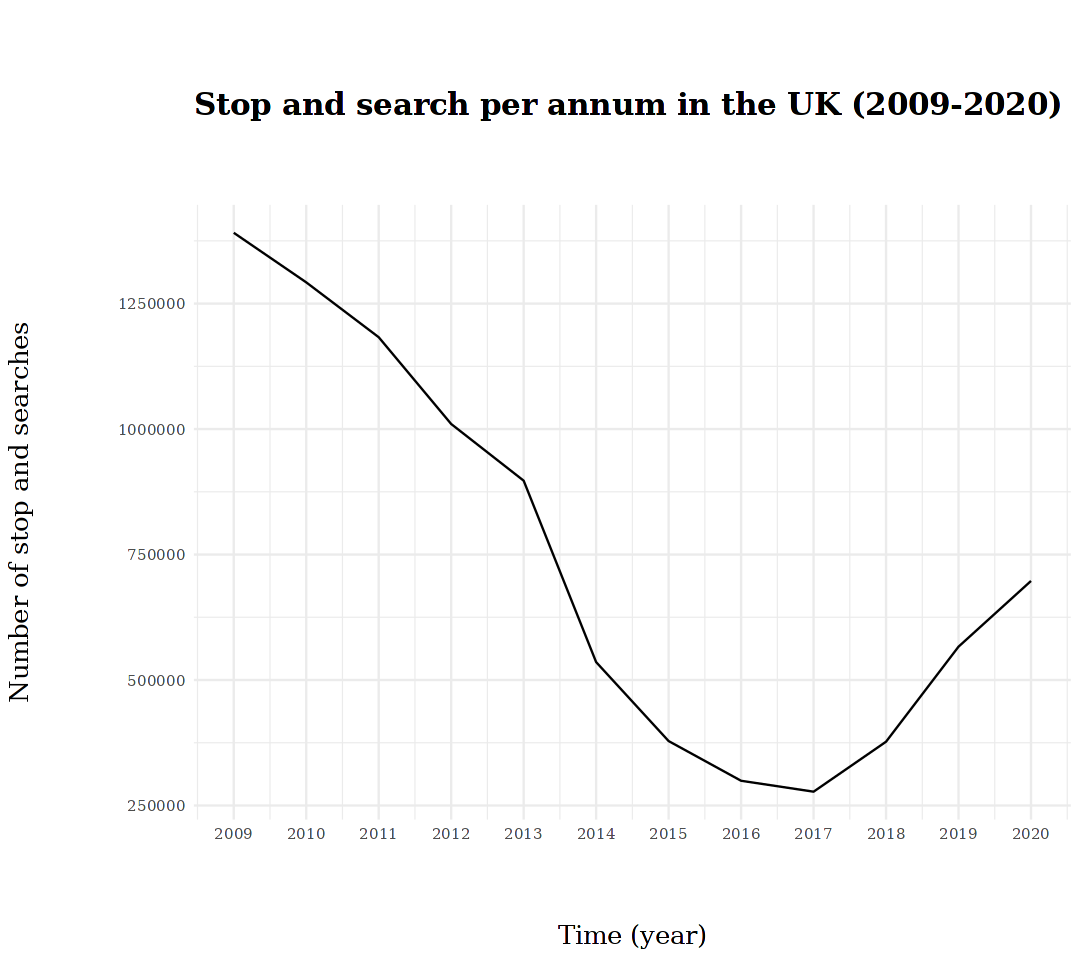

In [54]:
# Create a table grouped by ethnicity and time
stop_and_search_annual_totals <- stop_and_search %>% 
  group_by(time) %>% 
  filter(geography == 'All - including BTP', legislation_type == 'All', ethnicity == 'All') 

# Make the graph visible
options(repr.plot.width = 9, repr.plot.height = 8)

# Create a plot
ggplot() +
  geom_line(stop_and_search_annual_totals,
    mapping = aes(x=time, y=number_of_stop_and_searches)) +
    ggtitle("Stop and search per annum in the UK (2009-2020)") + 
  theme_minimal() +
  theme(text = element_text(family = "serif"),
       axis.title.x = element_text(size = 15, margin = margin(t = 50)),
       axis.title.y = element_text(size = 15, margin = margin(r = 50)),
       plot.title = element_text(size = 18, face="bold", margin=margin(50,50,50,0)),
    ) +
  labs(y = "Number of stop and searches", x = "Time (year)") +
  scale_x_continuous(n.breaks=10)

There was a total of 1,391,079 stop and searches in 2009 in the UK compared to 697,405 in 2020, with the lowest over the 2009-2020 period noted in 2017 (277,508).

Let's plot the changes over time per ethnic group, for the top groups:

`summarise()` has grouped output by 'ethnicity'. You can override using the
`.groups` argument.


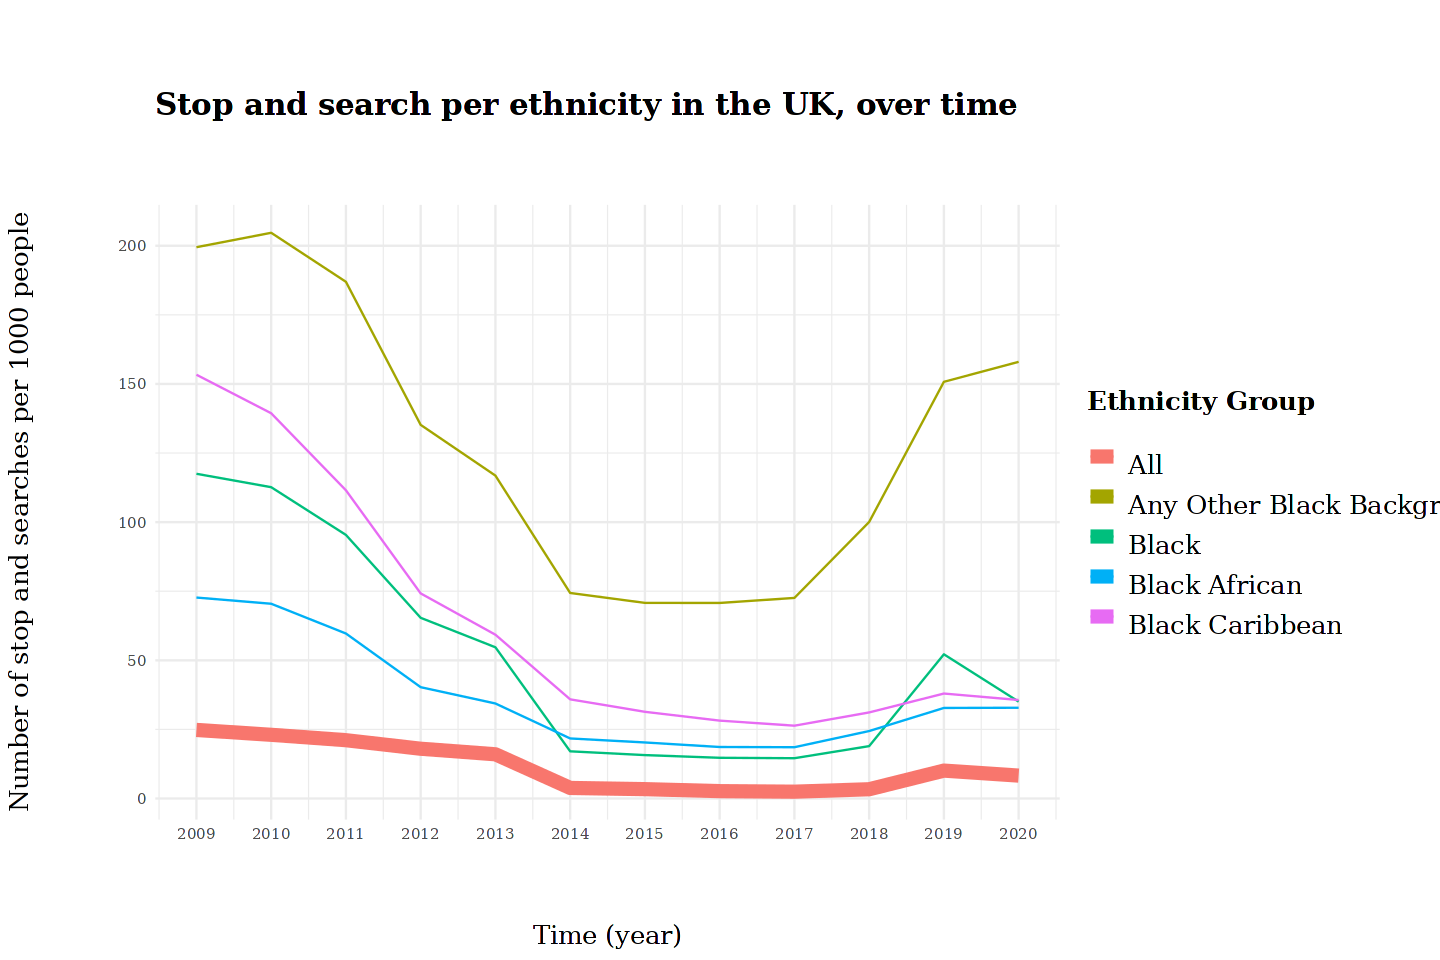

In [56]:
# Create a table grouped by ethnicity and time
stop_and_search_means_ethnicity <- stop_and_search %>% 
  group_by(ethnicity, time) %>% 
  filter(geography == 'All - including BTP') %>% 
  summarize(mean_rate=mean(rate_per_1_000_population_by_ethnicity_new, na.rm = TRUE))

# Make the graph visible
options(repr.plot.width = 12, repr.plot.height = 8)

# Create a plot
ggplot() +
  geom_line(stop_and_search_means_ethnicity %>%
    filter(grepl('Black', ethnicity), !grepl('White', ethnicity)),
    mapping = aes(x=time, y=mean_rate, color=ethnicity)) +
  geom_line(stop_and_search_means_ethnicity  %>%
    filter(grepl('All', ethnicity)),
    mapping = aes(x=time, y=mean_rate, color=ethnicity),size=3) +
    ggtitle("Stop and search per ethnicity in the UK, over time") + 
  theme_minimal() +
  theme(text = element_text(family = "serif"),
       axis.title.x = element_text(size = 15, margin = margin(t = 50)),
       axis.title.y = element_text(size = 15, margin = margin(r = 50)),
       plot.title = element_text(size = 18, face="bold", margin=margin(50,0,50,0)),
       legend.title = element_text(size = 15, face="bold"),
       legend.text = element_text(size = 15, margin = margin(t = 10)),
       legend.spacing.y = unit(0.5, 'cm')) +
  labs(y = "Number of stop and searches per 1000 people", x = "Time (year)") +
  guides(color = guide_legend(title = "Ethnicity Group")) +
  scale_x_continuous(n.breaks=10)

There is a notable drop in the number of stop and searches between 2010 and 2014, which is picking up however from 2017 onwards. Let's see if this applies to all types of stop and searches:

`summarise()` has grouped output by 'legislation_type'. You can override using
the `.groups` argument.


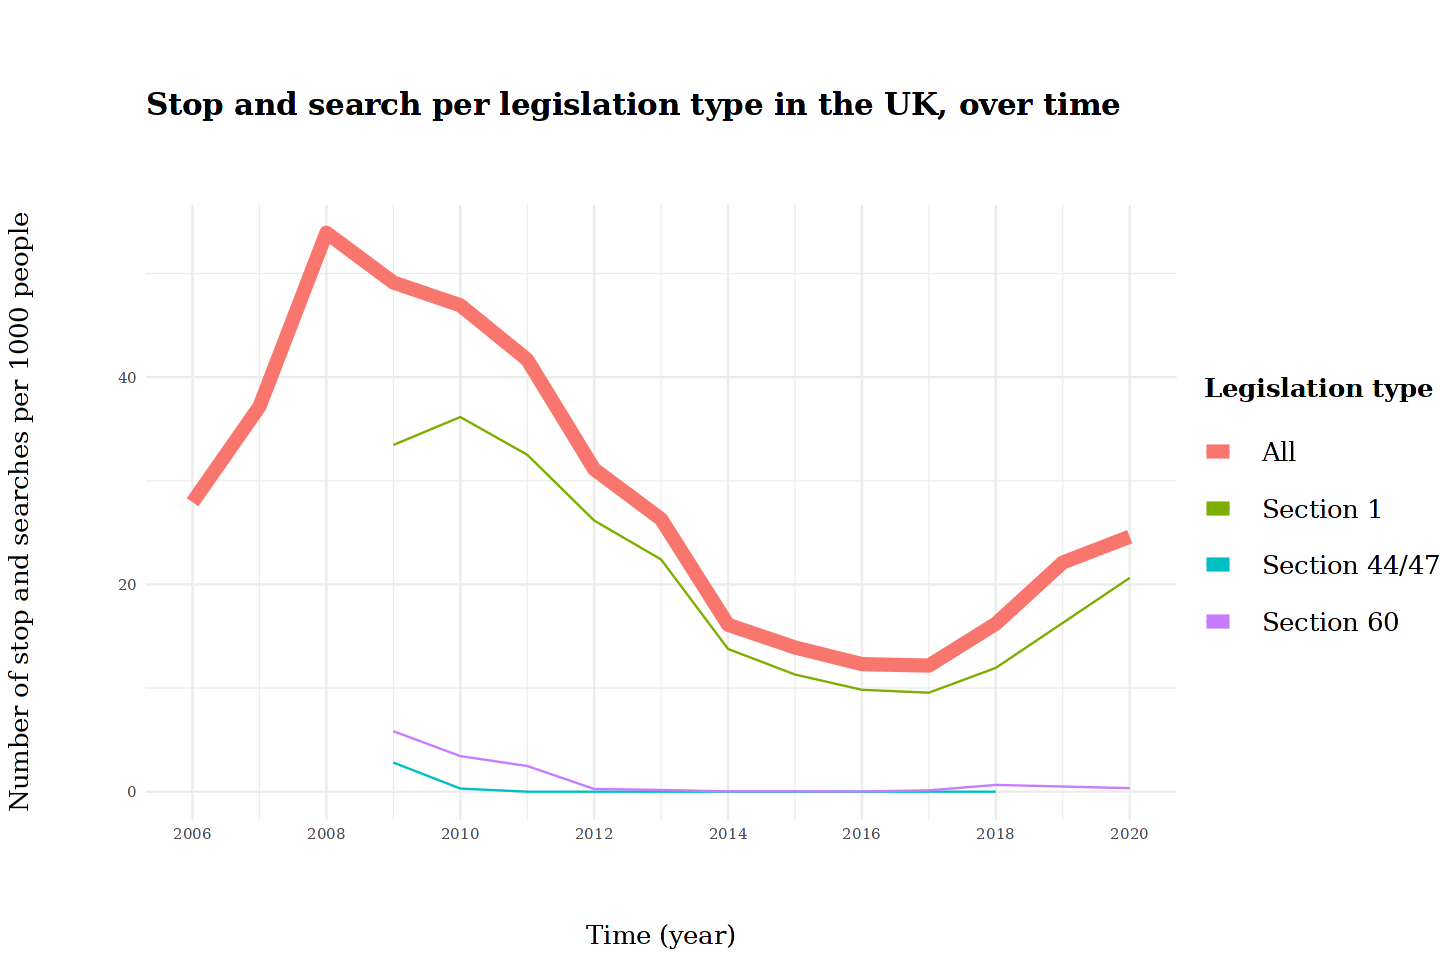

In [57]:
# Create a table grouped by legislation type and time
stop_and_search_means_legislation <- stop_and_search %>% 
  group_by(legislation_type, time) %>% 
  filter(geography == 'All - excluding BTP') %>% # since there are few All-including BTP entries filled-in 
  summarize(mean_rate=mean(rate_per_1_000_population_by_ethnicity_new, na.rm = TRUE))

# Create a plot
ggplot() +
  geom_line(stop_and_search_means_legislation %>%
    filter(!grepl('All', legislation_type)),
    mapping = aes(x=time, y=mean_rate, color=legislation_type)) +
  geom_line(stop_and_search_means_legislation  %>%
    filter(grepl('All', legislation_type)),
    mapping = aes(x=time, y=mean_rate, color=legislation_type),size=3) +
    ggtitle("Stop and search per legislation type in the UK, over time") + 
  theme_minimal() +
  theme(text = element_text(family = "serif"),
       axis.title.x = element_text(size = 15, margin = margin(t = 50)),
       axis.title.y = element_text(size = 15, margin = margin(r = 50)),
       plot.title = element_text(size = 18, face="bold", margin=margin(50,0,50,0)),
       legend.title = element_text(size = 15, face="bold"),
       legend.text = element_text(size = 15, margin = margin(10,10,10,10)),
       legend.spacing.y = unit(0.5, 'cm')) +
  labs(y = "Number of stop and searches per 1000 people", x = "Time (year)") +
  guides(color = guide_legend(title = "Legislation type")) +
  scale_x_continuous(n.breaks=10)

The graph shows that stops under legislations Section 44/47a (Terrorism Act) and Section 60 (Carrying of offensive weapons) have a minor contribution to the total over the years.

<a id="section-findings"></a>
## 5. Main findings  

* There was a total of 1,391,079 stop and searches in 2009 in the UK compared to 697,405 in 2020, with the lowest over the 2009-2020 period noted in 2017 (277,508), and picking thenafter.
* The top ethnicities to be stopped and searched in the UK are Any Other Black Background (128 per 1000 people), Black Caribbean (64), Black African (37), Bangladeshi (33) and Black (31). The bottow 5 include White (5.5), Chinese (4.1) and Arab (1.3). 
* The UK areas where most stop and searches take place are Greater London - City of London, Merseyside (Liverpool), Essex, South Yorkshire, South Wales. 
* Almost half of all stop and searches took place in the Metropolitan Police force area in London, and that can be explained by the fact that it comprises mostly office spaces (hence low number of resident population), it has increased security concerns as a major tourist destination and home of UK politics venues (hence the high number of stops and searches).


That's all. Thanks!